In [61]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import requests 

In [62]:
import datetime

In [63]:
import os 
os.chdir('E://bond-dex/bond-amm-research')

## CIR Model

In [64]:
class Rate(): 
    
    def __init__(self, T, N, r0, a, b, sigma): 
        self.T = T
        self.N = N 
        self.r0 = r0 
        self.a = a 
        self.b = b 
        self.sigma = sigma 
        self.dt = T / N
        
    def cir(self): 
        
        out = np.zeros(self.N)
        
        out[0] = r0 
        
        for i in range(self.N - 1):
            dr_i = self.a * (self.b - out[i]) * self.dt + self.sigma * np.sqrt(out[i]) * np.random.normal() * np.sqrt(self.dt)
            out[i + 1] = out[i] + dr_i
        
        return out

In [65]:
def calculate_x(r, r_min, r_max, A, t, T): 
    tau = T - t 
    return A * (r - r_min) * np.exp(-(r_max - r)**2 / (2 * (r_max - r_min)) * tau)


def calculate_y(r, r_min, r_max, A, t, T): 
    tau = T - t 
    return A * (r_max - r) * np.exp(-(r_max - r)**2 / (2 * (r_max - r_min)) * tau - r * tau)

In [66]:
T = 1/365
N = int(T * 365 * 24 * 60)

sigma=0.1
a=5
b=0.05

r0 = 0.05

x0 = 0.53

In [67]:
rate = Rate(T=T, N=N, r0=r0, a=a, b=b, sigma=sigma)

r = rate.cir()

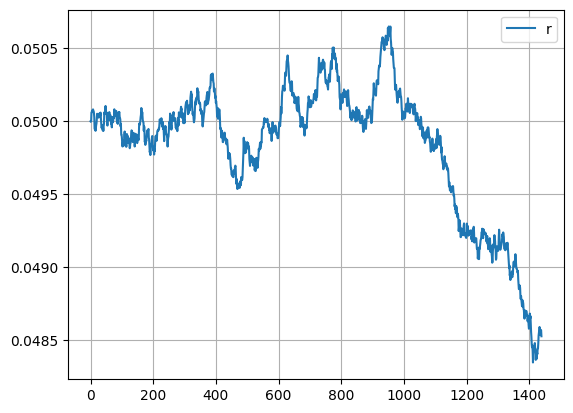

In [68]:
plt.plot(r, label='r')

plt.grid()

plt.legend()

In [69]:
from tqdm import tqdm

In [70]:
negative_rates = []
positive_rates = []
flat_rates = []

for _ in tqdm(range(3000)): 
    while True: 
        rate = Rate(T=T, N=N, r0=r0, a=a, b=b, sigma=sigma)
        r = rate.cir()
        if (r.max() - r.min()) < 2 * abs(r[-1] - r[0]):
            break
    if abs(r[-1] - r[0]) < 0.0001: 
        flat_rates.append(r)
    elif r[-1] > r[0]: 
        positive_rates.append(r)
    else: 
        negative_rates.append(r)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:31<00:00, 95.12it/s]


In [71]:
negative_rates = np.array(negative_rates)
positive_rates = np.array(positive_rates)
flat_rates = np.array(flat_rates)

In [72]:
negative_rates.shape, positive_rates.shape, flat_rates.shape

((1503, 1440), (1497, 1440), (0,))

## Simulate rate 

In [73]:
def scale_rate(a, b, rate):
    r0 = rate[0]
    r1 = rate[-1]
    new_rate = (rate - r0)/(r1-r0) * (b - a) + a
    return new_rate

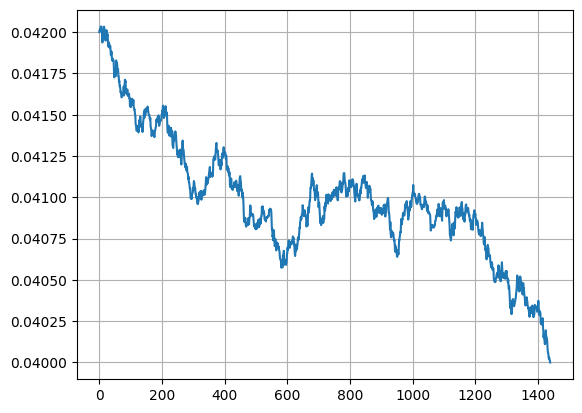

In [74]:
plt.plot(scale_rate(0.042, 0.04, negative_rates[0]))
plt.grid()

## AAVE ETH stable rate

In [75]:
from_date = datetime.datetime(2022, 1, 1).timestamp()
to_date = datetime.datetime(2023, 9, 1).timestamp()

url = f'https://aave-api-v2.aave.com/data/rates-history?reserveId=0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc20xB53C1a33016B2DC2fF3653530bfF1848a515c8c5&from={from_date}&to={to_date}&resolutionInHours=24'

In [76]:
response = requests.get(url)

In [77]:
df = pd.DataFrame(response.json())

In [78]:
df['trans_date'] = df.x.apply(lambda x: datetime.datetime(x['year'], x['month'] + 1, x['date']))

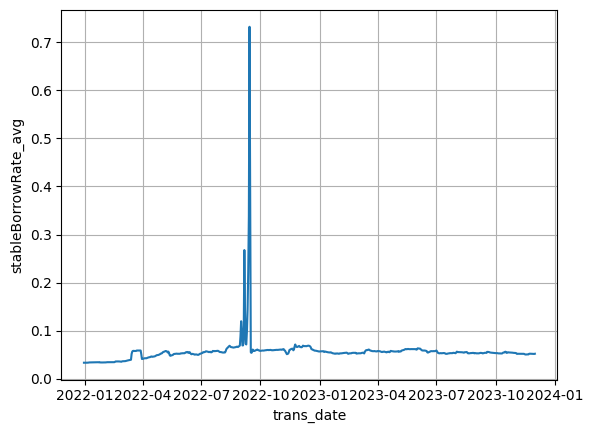

In [79]:
sns.lineplot(data=df, x='trans_date', y='stableBorrowRate_avg')

plt.grid()

In [44]:
# df = pd.read_csv('data/input/interest_rate/avve_eth_stable_rate.csv')

In [81]:
# df.to_csv('data/input/interest_rate/avve_eth_stable_rate.csv')

## Fit rate to data

In [82]:
T = 2 * 365 * 60 * 24

In [83]:
daily_r = df.query('trans_date >= "2021-07-01"').stableBorrowRate_avg.values

In [84]:
daily_r.shape

(701,)

In [86]:
minute_r = []

for i in range(len(daily_r) - 1): 
    r1 = daily_r[i]
    r2 = daily_r[i+1]
    
    if r2 > r1: 
        random_rate = positive_rates[np.random.choice(len(positive_rates), size=1)[0]]
    else: 
        random_rate = negative_rates[np.random.choice(len(negative_rates), size=1)[0]]
        
    new_r = scale_rate(r1, r2, random_rate)
    
    if min(new_r) < 0:
        print(i)
        print(new_r)
    
    minute_r.extend(new_r[1:])

In [87]:
min_m = max(0.001, min(minute_r))
max_m = max(minute_r)

In [88]:
minute_r = (np.array(minute_r) - min(minute_r)) / (max_m - min(minute_r)) * (max_m - min_m) + min_m

In [89]:
minute_r.shape

(1007300,)

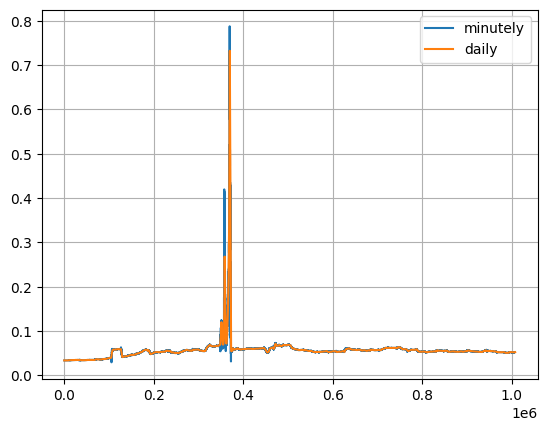

In [90]:
fig, ax = plt.subplots()

ax.plot(minute_r, label='minutely')

ax.plot(np.arange(len(daily_r)) * 24 * 60,daily_r, label='daily')

plt.legend()

plt.grid()

In [91]:
rate_df = pd.DataFrame({'timestamp': range(len(minute_r)), 'rate': minute_r})

In [92]:
rate_df.to_csv('data/input/interest_rate/eth_simulated_rate.csv', index=False)

In [93]:
rate_df = pd.read_csv('data/input/interest_rate/eth_simulated_rate.csv')

In [94]:
def calculate_x(r, r_min, r_max, A, t, T): 
    tau = T - t 
    return A * (r - r_min) * np.exp(-(r_max - r)**2 / (2 * (r_max - r_min)) * tau)


def calculate_y(r, r_min, r_max, A, t, T): 
    tau = T - t 
    return A * (r_max - r) * np.exp(-(r_max - r)**2 / (2 * (r_max - r_min)) * tau - r * tau)

In [187]:
T = 2
L = 365 * 24 * 60
N = min(int(T * L), rate_df.shape[0])

sigma=0.1
a=5
b=0.05

r0 = 0.05

x0 = 0.53
y0 = 0.5

In [188]:
r = rate_df.rate.values[:N]

In [189]:
r_min = 0.01
r_max = 0.1

In [190]:
r_min, r_max

(0.01, 0.1)

In [191]:
A = y0 / calculate_y(r0, r_min, r_max, A=1, t=0, T=T)

In [192]:
r.shape, N

((1007300,), 1007300)

In [193]:
x = calculate_x(r, r_min, r_max, A=A, t=np.arange(0, N) * (T / L), T=T)
y = calculate_y(r, r_min, r_max, A=A, t=np.arange(0, N) * (T / L), T=T)

In [194]:
x.shape

(1007300,)

<font color='red'>**Sample trades over time**</font>

In [195]:
dx = np.diff(x)
dy = np.diff(y)

In [196]:
def sample_trade(dx, dy):
    N = len(dx)
    
    trade_side = np.random.binomial(n=1, p=0.5, size=N)
    
    trade_size = np.where(trade_side == 1, dy, dx)
    
    return trade_side, trade_size

In [197]:
trade_sides, trade_volumes = sample_trade(dx, dy)

In [198]:
trade_sides.shape

(1007299,)

### Save simulated trade to csv

In [199]:
trade_df = pd.DataFrame({'dx': dx, 'dy': dy})
trade_df['action'] = trade_df.dx.apply(lambda x: 'lend' if x < 0 else 'borrow')
trade_df = trade_df.reset_index().rename(
    columns={'index': 'timestamp', 'dx': 'bond_volume'}
)[['timestamp', 'action', 'bond_volume']]
trade_df.bond_volume = np.abs(trade_df.bond_volume)

In [200]:
trade_df.groupby('action').agg({'bond_volume': 'describe'})

bond_volume                                                        \
             count      mean       std           min       25%       50%   
action                                                                     
borrow    511049.0  0.000448  0.004413  1.655454e-12  0.000010  0.000036   
lend      496250.0  0.000460  0.004444  3.757106e-12  0.000011  0.000038   

                            
             75%       max  
action                      
borrow  0.000117  0.330959  
lend    0.000119  0.269307

In [201]:
import enum

class Action(enum.Enum):
    
    OPEN_POSITION = 'open_position'
    LIQUIDATE = 'liquidate'
    
class Actor(enum.Enum): 
    
    LENDER = 'lender'
    BORROWER = 'borrower'

In [202]:
def make_action(df, timestamp_pivot): 
    
    df['position'] = df.actor_signal * df.sign
    
    df['actor'] = df.actor_signal.map({1: Actor.LENDER.value, -1: Actor.BORROWER.value})
    df['action'] = df.position.map({1: Action.OPEN_POSITION.value, -1: Action.LIQUIDATE.value})
    
    df['actor'] = np.where(df.timestamp <= timestamp_pivot, 
                           df.sign.map({1: Actor.LENDER.value, -1: Actor.BORROWER.value}), 
                           df.actor)
    df['action'] = np.where(df.timestamp <= timestamp_pivot, Action.OPEN_POSITION.value, df.action)
    
    return df

In [203]:
def make_new_input(df, initial_position=0.4, scale_time=1):
    
    df = df.copy()
    
    df['sign'] = df.action.map({'lend': 1, 'borrow': -1})
    df['net_volume'] = df.bond_volume * df.sign
    df['cum_position'] = df.sort_values(by='timestamp', ascending=True).groupby('action', as_index=False)['net_volume'].cumsum()
    
    time_pivot = df[(df.action == 'lend') & (df.cum_position < initial_position)].timestamp.max()
    actor = np.random.binomial(1, 0.5, size=df.shape[0]) * 2 - 1
    
    df['actor_signal'] = actor
    
    df = make_action(df, time_pivot)
    
    df.timestamp = df.timestamp *  scale_time
    
    return df[['timestamp', 'actor', 'action', 'bond_volume']]

In [204]:
tdf = make_new_input(trade_df)

In [205]:
tdf['interest_rate'] = r[:tdf.shape[0]]

In [206]:
tdf

,timestamp,actor,action,bond_volume,interest_rate
0,0,borrower,open_position,0.000009,0.033447
1,1,lender,open_position,0.000009,0.033448
2,2,borrower,open_position,0.000012,0.033447
3,3,lender,open_position,0.000024,0.033448
4,4,borrower,open_position,0.000008,0.033446
...,...,...,...,...,...
1007294,1007294,borrower,open_position,0.000034,0.052073
1007295,1007295,borrower,open_position,0.000039,0.052076
1007296,1007296,lender,open_position,0.000024,0.052079
1007297,1007297,borrower,liquidate,0.000123,0.052077


In [207]:
import datetime

In [211]:
tdf['time_dt'] = datetime.datetime(2021, 12, 31).timestamp() + tdf.timestamp * 60

In [212]:
tdf['time_dt'] = tdf.time_dt.apply(lambda x: datetime.datetime.fromtimestamp(x))

<Axes: xlabel='time_dt', ylabel='interest_rate'>

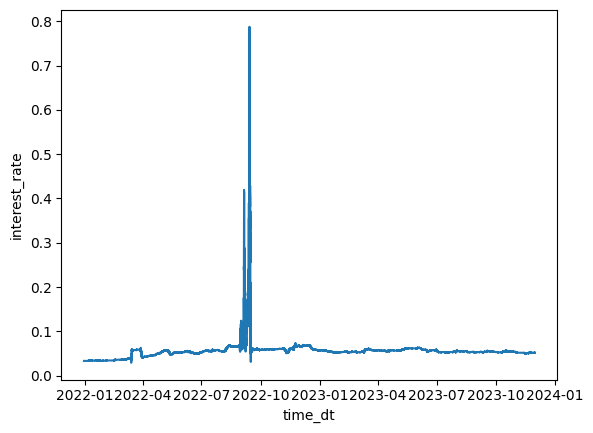

In [213]:
sns.lineplot(data=tdf, x='time_dt', y='interest_rate')

<Axes: >

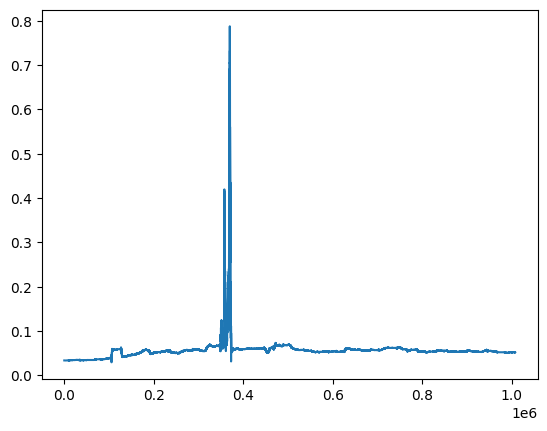

In [214]:
tdf.interest_rate.plot()

In [215]:
tdf.to_csv('data/input/dx_aave_eth.csv')

In [123]:
trade_df.to_csv('data/input/simulated_eth_trade2.csv', index=False)

In [122]:
r_min, r_max

(0.05130447917255321, 0.7187344090554093)

In [40]:
orders = pd.read_csv('data/input/simulated_eth_trade.csv')

In [41]:
orders.groupby('action').agg({'cash_volume': 'describe'})

cash_volume                                                        \
             count      mean       std           min       25%       50%   
action                                                                     
borrow    262292.0  0.000680  0.001531  1.137810e-09  0.000074  0.000228   
lend      263307.0  0.000679  0.001504  2.730427e-10  0.000073  0.000227   

                            
             75%       max  
action                      
borrow  0.000642  0.048553  
lend    0.000650  0.045800